In [1]:
import os
import re

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.figsize'] = (16, 9)

In [4]:
ROOT_DIR = "RawData"

In [79]:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("notebook", font_scale = 1.5)

# 1. Upload Datasets

In [70]:
def get_data(filename, dir = ROOT_DIR, force_download = False):
    if force_download or not os.path.exists(filename):
        data = pd.ExcelFile(os.path.join(dir, filename))
    return data

In [71]:
BE_data = get_data('BE_RawData_VPython.xlsx')
FR_data = get_data('FR_RawData_VPython.xlsx')
EU_data = get_data('EU_RawData_VPython.xlsx')

In [72]:
print("BE_data, sheet names = \n", BE_data.sheet_names, "\n\n", 
      "FR_data, sheet names = \n", FR_data.sheet_names, "\n\n", 
      "EU_data, sheet names = \n", EU_data.sheet_names, "\n")

BE_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'FlatGlassInd_GlassInd', 'RawMat_GlassInd_ABS'] 

 FR_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'RawMat_PlateGlass', 'RawMat_WindowGlass', 'RawMat_FloatGlass', 'RawMat_FlatGlass_ABS', 'pollution'] 

 EU_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'EnergyUse', 'pollution', 'production costs'] 



# 2. Production since 1945 in Belgium, France, and the European Union

## a. Production of flat glass

In [101]:
#Creating a DataFrame only with production data
FR_Prod = FR_data.parse('prod').set_index('year')
BE_Prod = BE_data.parse('prod').set_index('year')

#Creating a new DataFrame for Belgian and French flat glass production

BE_FR_Prod = FR_Prod[['flat glass INSEE, kt',
                      'flat glass SESSI, kt']].copy()
BE_FR_Prod.rename(columns={'flat glass INSEE, kt': 'FR, INSEE', 
                           'flat glass SESSI, kt': 'FR, SESSI'},
                  inplace=True)

BE_FR_Prod['Belgium'] = BE_Prod['flat glass, kt']

BE_FR_Prod

,"FR, INSEE","FR, SESSI",Belgium
year,,,
1945,108.3,NaN,NaN
1946,173.7,NaN,NaN
1947,198.3,NaN,NaN
1948,220.2,NaN,NaN
1949,191.3,NaN,NaN
...,...,...,...
2016,NaN,NaN,NaN
2017,NaN,NaN,NaN
2018,NaN,NaN,NaN


In [102]:
EU_Prod = EU_data.parse('prod').set_index(['Nbr of countries', 'year'])
EU_Prod

flat glass, kt architectural glass/flat glass, %  \
Nbr of countries year                                                     
6                1945             NaN                               NaN   
                 1946             NaN                               NaN   
                 1947             NaN                               NaN   
                 1948             NaN                               NaN   
                 1949             NaN                               NaN   
...                               ...                               ...   
28               2015          9641.0                               NaN   
                 2016          9835.0                               NaN   
                 2017         10665.0                               NaN   
                 2018         10643.0                               0.8   
                 2019         10840.0                               NaN   

                       IGU, "000 m²  float glass w/ reflecting layer, "000 m²  \
Nbr of countries year                                                           
6                1945           NaN                                       NaN   
                 1946           NaN                                       NaN   
                 1947           NaN                                       NaN   
                 1948           NaN                                       NaN   
                 1949           NaN                                       NaN   
...                             ...                                       ...   
28               2015    116000.000                                290030.243   
                 2016    114000.000                                302527.228   
                 2017    121600.000                                286038.313   
                 2018    117011.436                                287262.007   
                 2019    121061.246                                296506.851   

                       LSG for bldg, "000 m²  TSG for bldg, "000 m²  
Nbr of countries year                                                
6                1945                    NaN                    NaN  
                 1946                    NaN                    NaN  
                 1947                    NaN                    NaN  
                 1948                    NaN                    NaN  
                 1949                    NaN                    NaN  
...                                      ...                    ...  
28               2015              94520.954              57000.000  
                 2016              85681.248              55864.316  
                 2017              86735.168              57552.178  
                 2018              84718.143              50337.613  
                 2019              95316.274              51128.069  

[90 rows x 6 columns]

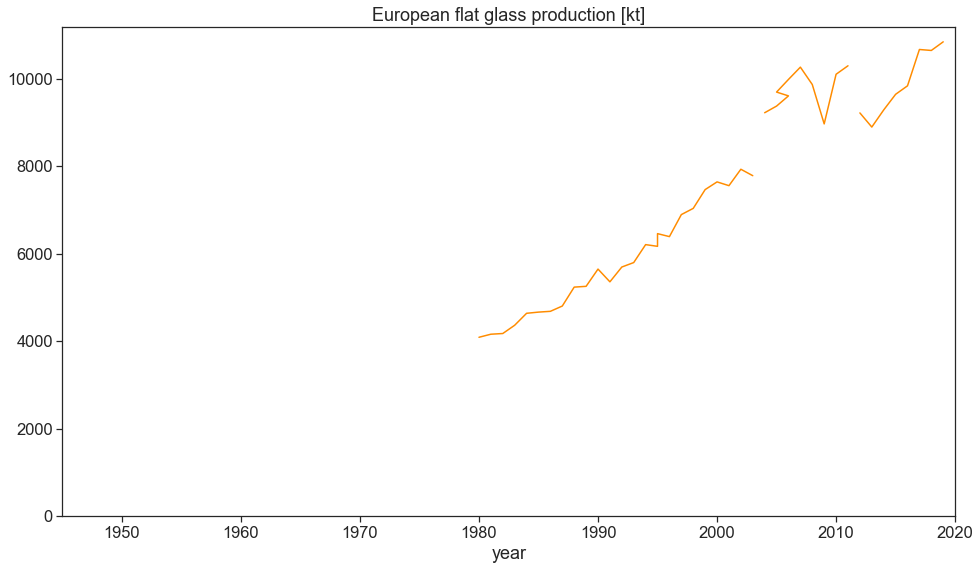

In [109]:
#Plot EU flat glass production
EU_Prod.reset_index().plot('year', 'flat glass, kt', 
                           title='European flat glass production [kt]',
                           color='darkorange', legend=False,
                           xlim=(1945,2020), ylim=0)

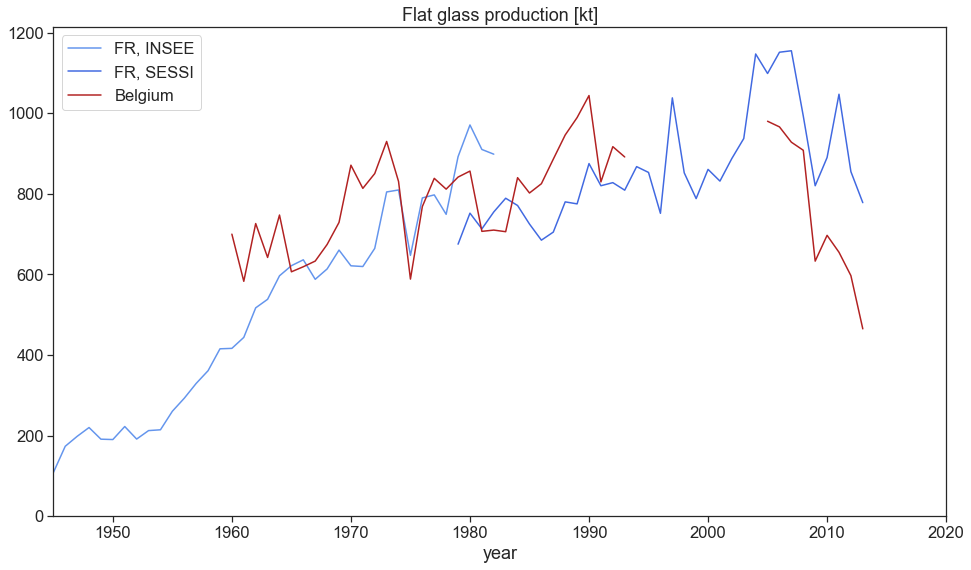

In [107]:
#Plot FR and BE flat glass production

BE_FR_Prod.plot(color=['cornflowerblue', 'royalblue', 'firebrick'],
               title='Flat glass production [kt]', 
                xlim=(1945,2020), ylim=0)

## b. Production of architectural flat glass

In [124]:
#Share of building glazing in the French production of flat glass
RatioFR = FR_Prod[['architectural glass/flat glass, %']].dropna()
RatioFR

,"architectural glass/flat glass, %"
year,
1947,0.90
1952,0.80
1962,0.68
1968,0.50
1980,0.50
1994,0.50
2002,0.52
2004,0.49


In [125]:
#Share of building glazing in the European production of flat glass
RatioEU = EU_Prod[['architectural glass/flat glass, %']].dropna()
RatioEU

architectural glass/flat glass, %
Nbr of countries year                                               
9                1978                                          0.572
15               1995                                               
                 1996                                           0.52
28               2018                                            0.8

In [34]:
RatioFR.isnull().sum()

architectural glass/flat glass, %    0
dtype: int64

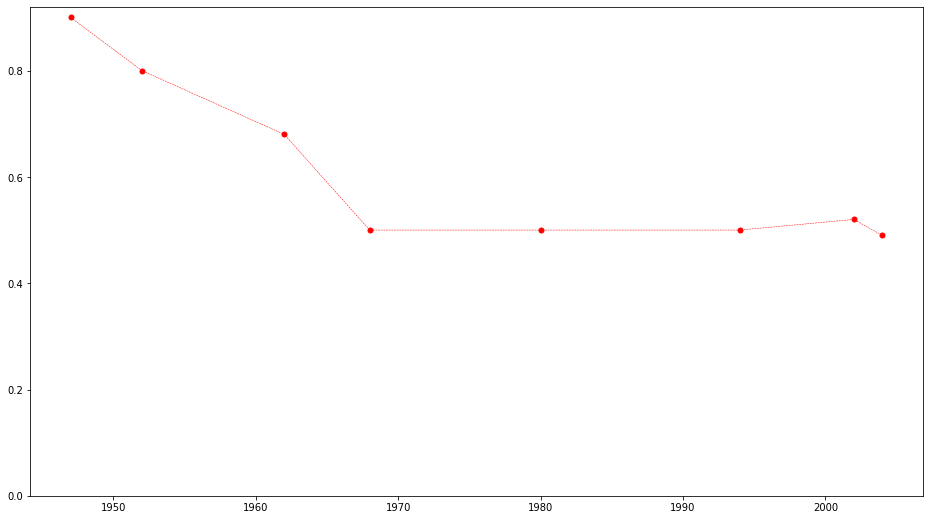

In [16]:
f, ax = plt.subplots(1)

xdata = RatioFR["year"]
ydata = RatioFR["architectural glass/flat glass, %"]
ax.plot(xdata, ydata, 
        color='red', marker='o', markersize=5,
        linewidth=0.5, linestyle='dashed'
       )

ax.set_ylim(ymin=0)
plt.show(f)

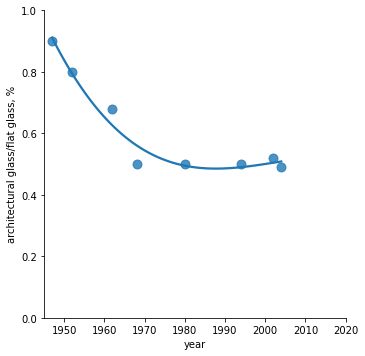

In [17]:
g = sns.lmplot(x="year", y="architectural glass/flat glass, %", data=RatioFR,
           order=3, ci=None, scatter_kws={"s": 80})
g.set(ylim=(0, 1), xlim=(1945, 2020))

## c. Production of insulating glass units